In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score, silhouette_score, mean_squared_error, mean_absolute_error 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# create dataframes of csv
player_stats_salaries_df = pd.read_csv('./data/player_stats_salaries.csv')


In [3]:
player_stats_salaries_df.head()

,Unnamed: 0,Player,Club,POS,GP,GS,MINS,G,A,SHTS,...,FC,FS,OFF,YC,RC,SOG%,Year,Season,Base Salary,Base Guaranteed Comp.
0,0,chris wondolowski,SJ,F,32,31,2813,27,7,127,...,19,25,28,3,0,43.31,2012,reg,300000.0,300000.00
1,1,kenny cooper,NY,F,33,26,2505,18,3,84,...,36,28,20,3,0,54.76,2012,reg,275000.0,292500.00
2,2,alvaro saborio,RSL,F,31,26,2390,17,3,87,...,35,37,37,5,0,45.98,2012,reg,350000.0,405625.00
3,3,robbie keane,LA,F,28,28,2519,16,9,94,...,15,34,27,0,0,45.74,2012,reg,2917241.0,3417242.75
4,4,thierry henry,NY,F,25,24,2108,15,12,88,...,18,26,24,5,0,42.05,2012,reg,5000000.0,5600000.00


In [4]:
# remove Unnamed column
player_stats_salaries_df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
player_stats_salaries_df.rename(columns={'PKG/A': 'Penalty_Kick_Conversion_Rate', 'G/90min': 'Goals_per_90_Minutes', 
                                          'A/90min': 'Assists_per_90_Minutes', 'POS': 'Position', 'GP': 'Games_Played',
                                         'GS': 'Games_Started', 'MINS': 'Total_Minutes_Played', 'G': 'Goals',
                                         'A': 'Assists', 'SHTS': 'Shots', 'SOG': 'Shots_On_Goal', 
                                        'GWG': 'Game_Winning_Goals', 'HmG': 'Home_Goals', 'RdG': 'Road_Goals',
                                        'SC%': 'Shots_Conversion', 'GWA': 'Game_Winning_Assists',
                                        'HmA': 'Home_Assists', 'RdA': 'Road_Assists', 'FC': 'Fouls_Committed',
                                        'FS': 'Fouls_Suffered', 'OFF': 'Offsides', 'YC': 'Yellow_Cards',
                                        'RC': 'Red_Cards', 'SOG%': 'Shots_On_Goal_Rate'}, inplace=True)

In [6]:
player_stats_salaries_df[["Penalty_Kicks_Scored", "Penalty_Kicks_Taken"]] = player_stats_salaries_df['Penalty_Kick_Conversion_Rate'].str.split("/", expand=True)
player_stats_salaries_df['Penalty_Kick_Conversion_Rate'] = player_stats_salaries_df["Penalty_Kicks_Scored"].astype(float) / player_stats_salaries_df["Penalty_Kicks_Taken"].astype(float)
player_stats_salaries_df['Penalty_Kick_Conversion_Rate'].fillna(value=0, inplace=True)

In [7]:
player_stats_salaries_df['Penalty_Kicks_Scored'] = player_stats_salaries_df['Penalty_Kicks_Scored'].astype(int)
player_stats_salaries_df["Penalty_Kicks_Taken"]= player_stats_salaries_df['Penalty_Kicks_Taken'].astype(int)

In [8]:
player_stats_salaries_df['Shots_On_Goal_Rate'].fillna(value=0, inplace=True)

In [9]:
player_stats_salaries_df = player_stats_salaries_df.drop(columns=['Player', 'Club', 'Season', 'Year',
                                                           
                                                           ])

In [10]:
player_stats_salaries_df['Position'].value_counts()

Position
M      1706
D      1619
F       953
M-F      93
D-M      80
F-M      38
M-D      28
Name: count, dtype: int64

In [11]:
for i in range(len(player_stats_salaries_df)):
    pos = player_stats_salaries_df.at[i, 'Position']
    if pos == 'M-F':
        player_stats_salaries_df.at[i, 'Position'] = 'M'
    elif pos == 'D-M':
        player_stats_salaries_df.at[i, 'Position'] = 'D'
    elif pos == 'F-M':
        player_stats_salaries_df.at[i, 'Position'] = 'F'
    elif pos == 'M-D':
        player_stats_salaries_df.at[i, 'Position'] = 'M'

In [12]:
player_stats_salaries_df['Position'].value_counts()

Position
M    1827
D    1699
F     991
Name: count, dtype: int64

In [25]:
mid_df = player_stats_salaries_df[player_stats_salaries_df['Position'] == 'M']
def_df = player_stats_salaries_df[player_stats_salaries_df['Position'] == 'D']
fow_df = player_stats_salaries_df[player_stats_salaries_df['Position'] == 'F']

In [26]:
mid_df.head()

,Position,Games_Played,Games_Started,Total_Minutes_Played,Goals,Assists,Shots,Shots_On_Goal,Game_Winning_Goals,Penalty_Kick_Conversion_Rate,...,Fouls_Committed,Fouls_Suffered,Offsides,Yellow_Cards,Red_Cards,Shots_On_Goal_Rate,Base Salary,Base Guaranteed Comp.,Penalty_Kicks_Scored,Penalty_Kicks_Taken
7,M,31,26,2339,12,4,71,29,6,1.0,...,19,49,5,3,0,40.85,155000.0,166250.00,1,1
10,M,25,23,1934,11,3,75,35,2,1.0,...,20,37,15,0,0,46.67,138000.0,148843.79,1,1
12,M,26,25,2256,9,14,65,29,3,1.0,...,33,43,5,6,0,44.62,2400000.0,2400000.00,2,2
13,M,27,25,2194,9,8,32,15,1,1.0,...,43,16,0,5,0,46.88,130000.0,149333.25,6,6
18,M,34,34,2990,9,2,55,27,1,0.0,...,29,61,10,2,0,49.09,190000.0,195000.00,0,0


In [27]:
mid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1827 entries, 7 to 4515
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Position                      1827 non-null   object 
 1   Games_Played                  1827 non-null   int64  
 2   Games_Started                 1827 non-null   int64  
 3   Total_Minutes_Played          1827 non-null   int64  
 4   Goals                         1827 non-null   int64  
 5   Assists                       1827 non-null   int64  
 6   Shots                         1827 non-null   int64  
 7   Shots_On_Goal                 1827 non-null   int64  
 8   Game_Winning_Goals            1827 non-null   int64  
 9   Penalty_Kick_Conversion_Rate  1827 non-null   float64
 10  Home_Goals                    1827 non-null   int64  
 11  Road_Goals                    1827 non-null   int64  
 12  Goals_per_90_Minutes          1827 non-null   float64
 13  Shots_Co

In [28]:
mid_df.describe()

,Games_Played,Games_Started,Total_Minutes_Played,Goals,Assists,Shots,Shots_On_Goal,Game_Winning_Goals,Penalty_Kick_Conversion_Rate,Home_Goals,...,Fouls_Committed,Fouls_Suffered,Offsides,Yellow_Cards,Red_Cards,Shots_On_Goal_Rate,Base Salary,Base Guaranteed Comp.,Penalty_Kicks_Scored,Penalty_Kicks_Taken
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,...,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1.827000e+03,1.827000e+03,1827.000000,1827.000000
mean,16.837438,12.736727,1134.914614,1.743842,2.249042,18.139026,6.143952,0.477285,0.071683,1.051450,...,16.827039,17.313082,1.820471,2.261631,0.123153,25.520974,3.488503e+05,3.898738e+05,0.179529,0.232074
std,10.906672,10.629537,918.289206,2.756861,3.094503,20.192186,7.836121,0.955702,0.246563,1.778409,...,15.730955,17.967887,3.468298,2.474065,0.365016,20.649106,7.534563e+05,8.419539e+05,0.727761,0.860984
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.375000e+04,3.375000e+04,0.000000,0.000000
25%,7.000000,2.000000,253.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,6.562500e+04,7.250000e+04,0.000000,0.000000
50%,18.000000,11.000000,998.000000,1.000000,1.000000,11.000000,3.000000,0.000000,0.000000,0.000000,...,13.000000,12.000000,0.000000,1.000000,0.000000,27.270000,1.250000e+05,1.440000e+05,0.000000,0.000000
75%,27.000000,22.000000,1913.000000,2.000000,3.000000,28.000000,9.000000,1.000000,0.000000,1.000000,...,26.000000,26.000000,2.000000,4.000000,0.000000,38.100000,3.000000e+05,3.250000e+05,0.000000,0.000000
max,35.000000,34.000000,3060.000000,21.000000,20.000000,116.000000,50.000000,9.000000,1.000000,14.000000,...,86.000000,110.000000,31.000000,13.000000,3.000000,100.000000,6.660000e+06,7.167500e+06,7.000000,8.000000


In [17]:
mid_df = mid_df[mid_df['Games_Played'] != 0]
mid_df

,Position,Games_Played,Games_Started,Total_Minutes_Played,Goals,Assists,Shots,Shots_On_Goal,Game_Winning_Goals,Penalty_Kick_Conversion_Rate,...,Fouls_Committed,Fouls_Suffered,Offsides,Yellow_Cards,Red_Cards,Shots_On_Goal_Rate,Base Salary,Base Guaranteed Comp.,Penalty_Kicks_Scored,Penalty_Kicks_Taken
7,M,31,26,2339,12,4,71,29,6,1.0,...,19,49,5,3,0,40.85,155000.0,166250.00,1,1
10,M,25,23,1934,11,3,75,35,2,1.0,...,20,37,15,0,0,46.67,138000.0,148843.79,1,1
12,M,26,25,2256,9,14,65,29,3,1.0,...,33,43,5,6,0,44.62,2400000.0,2400000.00,2,2
13,M,27,25,2194,9,8,32,15,1,1.0,...,43,16,0,5,0,46.88,130000.0,149333.25,6,6
18,M,34,34,2990,9,2,55,27,1,0.0,...,29,61,10,2,0,49.09,190000.0,195000.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4502,M,10,7,683,0,0,9,5,0,0.0,...,6,14,3,1,0,55.56,215000.0,229250.00,0,0
4507,M,17,9,822,0,0,10,4,0,0.0,...,15,11,0,5,0,40.00,252000.0,283500.00,0,0
4513,M,15,8,769,0,0,13,4,0,0.0,...,12,5,0,2,0,30.77,307000.0,307000.00,0,0
4514,M,21,20,1701,0,0,14,1,0,0.0,...,44,14,0,4,0,7.14,320000.0,325000.00,0,0


In [29]:
mid_df.drop(columns='Position', inplace=True)

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_94937/3095935418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mid_df.drop(columns='Position', inplace=True)


In [30]:
X = mid_df.drop(columns='Base Guaranteed Comp.')
y = mid_df['Base Guaranteed Comp.']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

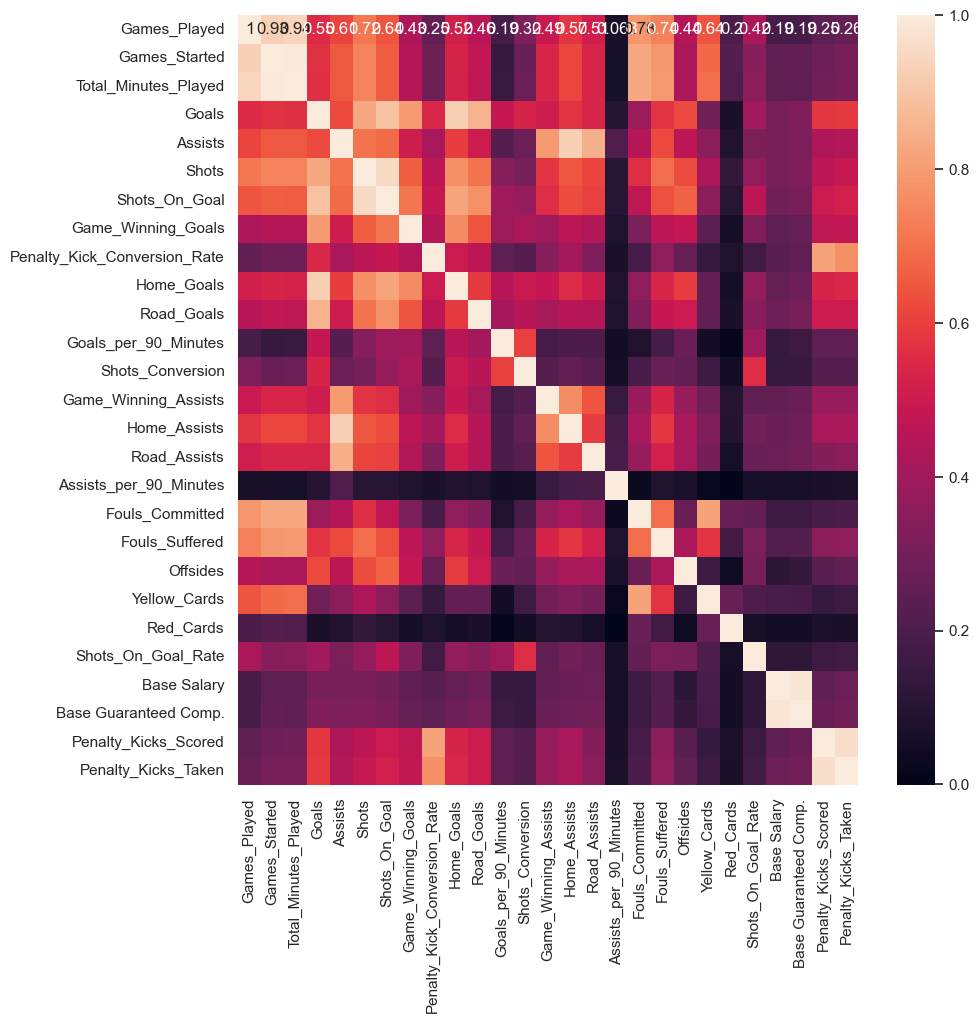

In [31]:
sns.set(rc={'figure.figsize': (10, 10)})

sns.heatmap(mid_df.corr(), annot=True);

In [32]:
lr = LinearRegression()
scaler = StandardScaler()
X_train_sc= scaler.fit_transform(X_train)
X_test_sc= scaler.transform(X_test)

lr.fit(X_train_sc, y_train)
y_pred = lr.predict(X_train_sc)

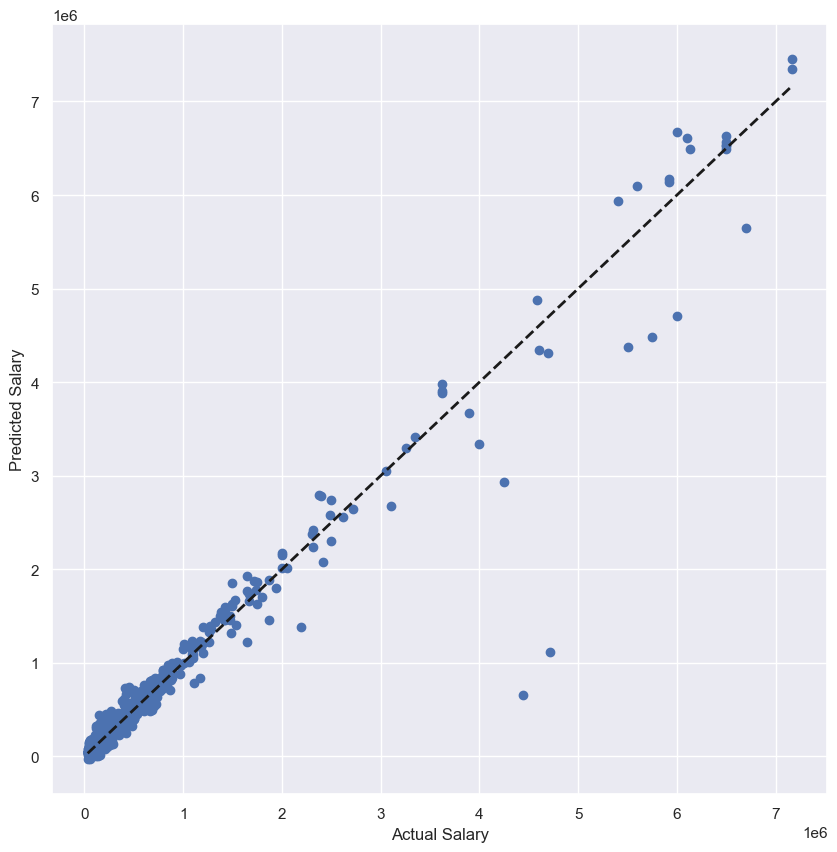

In [33]:
plt.scatter(y_train, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.show()

In [34]:
lr_mse = np.mean(cross_val_score(lr, X_train_sc, y_train, cv=5, scoring = 'neg_mean_squared_error'))
lr_mse

-36950092857.61268

In [35]:
rmse = np.sqrt(-lr_mse)
rmse

192224.06940238437

In [37]:
lr_r2 = r2_score(y_train, y_pred)
lr_r2

0.957027730002515